**TITLE**: Reinforcement Learning for Stock Market  
**AUTHOR**: Pablo Carrera Flórez de Quiñones  
**DATE**: June 2020  

# INTRODUCTION

## Objectives

## Libraries

In [166]:
# Basics
import numpy as np
import pandas as pd
import random
import logging
from datetime import datetime
from collections import deque

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go

# Deep Learning
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.optimizers import Adam

# Reinforcement Learning
import gym
from gym import spaces

# Own
from utils_finance import download_stock, plot_candlestick, compute_returns, plot_cummulative_returns

## Logging

In [2]:
# Create the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

##### Stream logging
# Set the format
formatter_stream = logging.Formatter('%(asctime)s : %(levelname)s %(message)s')

# Create a handler for showing the logs
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
stream_handler.setFormatter(formatter_stream)

# Add the handlers to the logger
logger.addHandler(stream_handler)
#####
    
##### File logging
# Set the format
formatter_file = logging.Formatter('%(asctime)s %(name)s %(lineno)d:%(levelname)s %(message)s')

# Create a handler for saving the logs
file_handler = logging.FileHandler('logging.log', mode = 'w')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter_file)

# Add the handlers to the logger
logger.addHandler(file_handler)
#####

# DATA

The first step is to obtain data from stock market. The majority of APIs that provide this data in real-time are private, but we can use the Yahoo! API in order to get the daily values of the stock's prices. We have developed the function *download_stock* with this purpose.

In [167]:
# Import data
data = download_stock(stock = ['AAPL'], date_start = datetime(2000, 1, 1), date_end = datetime(2019, 12, 31))
display(data.head())

2020-06-07 19:48:40,128 : INFO Download data from AAPL


,Open,Low,Close,High,Volume
2000-01-03,3.745536,3.631696,3.997768,4.017857,133949200.0
2000-01-04,3.866071,3.613839,3.660714,3.950893,128094400.0
2000-01-05,3.705357,3.678571,3.714286,3.948661,194580400.0
2000-01-06,3.790179,3.392857,3.392857,3.821429,191993200.0
2000-01-07,3.446429,3.410714,3.553571,3.607143,115183600.0


We can plot all this data at the same time using the so called candlestick charts. In this chart, each instance is represented by a rectanular box with whispers. If the stock isred it means that the closing price is lower than the opening price, consequently the lower edge ofthe box denotes the closing price of the stock this day, and the upper box denotes the opening price.If the stock is green it means that the closing price is higher than the opening price, consequentlythe lower edge of the box denotes the opening price of the stock this day, and the upper box denotesthe closing price.  The lowest whisper, called lower shadow, always denotes the lowest price of thestock this day, and the upper whisper, called upper shadow, always the highest price.  

In [168]:
# Plot candlestick chart
logger.info('Plot AAPL candlestick')
plot_candlestick(data, tick = 'AAPL', currency = '$')

2020-06-07 19:48:40,834 : INFO Plot AAPL candlestick


The next step, in this field, is usually to compute the returns of the $i$-th stock's price series $p^{(i)}_t$. The returns $r^{(i)}_t$ are simply defined as the percentual change in the price of the stock

$$ r^{(i)}_t = \frac{p^{(i)}_t - p^{(i)}_{t-1}}{p^{(i)}_{t-1}} $$

and are usually ploted as a cummultive product

$$ R^{(i)}_t = \prod_{j = 0}^t (1 + r^{(i)}_j) $$

2020-06-07 19:48:41,208 : INFO Plot AAPL cummulative returns


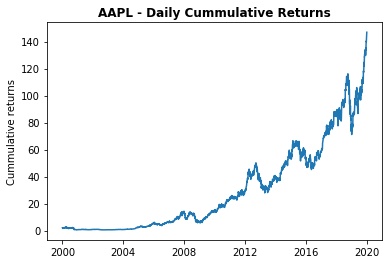

In [169]:
# Plot AAPL returns
logger.info('Plot AAPL cummulative returns')
plot_cummulative_returns(data, tick = 'AAPL')

# DEFINITION OF ENVIRONMENTS

As we said an environment comprise everything outside the agent, so its code implementation has to contain all the functionality to allow the agent to interact with it and to learn. We are going to implement this environment according to the guidelines of OpenAI gym \[1\], one on the most used libraries to develop reinforcement learning applications. The environments are then defined as a class with the following methods:
* __init(self)__: define initial information of the environment such as the observation space or the action space.
* __reset(self)__: reset the environment's state.
* __step(self, action)__: step the environment by one timestep. Returns
    * _observation_ (object): an environment-specific object representing our observation of the environment. 
    * _reward_ (float): amount of reward achieved by the previous action.
    * _done_ (boolean): whether it’s time to reset the environment again.
    * _info_ (dict): diagnostic information useful for debugging. 
* __render(self, mode='human')__: render one frame of the environment.

## First environment

The first thing we need is to define how an agent should perceive its environment, that is, we need to consider how a human will perform the task. To formulate RL problem, we need to define three things: 
* **Observations**: we can think about which kind of observations uses a human when trading:  
    * Historical values of prices, where each time-step has open, low, close and high prices for that day.  
    * Current value of openeded positions of the trading agent.  
    * Current profit or loss computed from our current position respect to when we adquired it.  
* **Actions**: there are three posible actions at any time-step: 
    * Hold: do nothing, that is, skip the time-step without taking actions.  
    * Buy: open a position, that is, buy a share and save the price at this time to compute the profit.  
    * Sell: close a position, that is, sell a share and save the price at this time to compute the profit.  
* **Rewards**:
    * As a first approximation we can use returns.

In [183]:
class FirstEnvironment(gym.Env):
    '''
    Reinforcement Leaning environment representing a Stock Market with a single stock.
    '''
    def __init__(self, data, time_horizon = 10, time_skip = 1):
        '''
        Initialization of the environment.
        
        Args:
            data (pd.DataFrame): [Open,Low,Close,High,Volume] historical prices of a stock
            time_horizon (int): number of timesteps inside each state
            time_skip (int): number of timesteps to skip between states
        '''
        # Get the data
        self.data = data['Close']
        self.time_horizon = time_horizon
        self.time_skip = time_skip
        
        # Define actions
        self.actions   = {0 : 'Hold', 1 : 'Buy', 2 : 'Sell'}
        
        # Save useful values
        self.n_timesteps = self.data.shape[0] 
        self.n_features  = 1
        self.n_actions   = len(self.actions)
        self.state_shape = (self.time_horizon, self.n_features)
        
        # Define spaces
        self.action_space      = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.state_shape, dtype=np.float32)

        # Initialize the environment
        self.reset()

    def reset(self):
        '''
        Initalize temporal variables.
        '''
        # Intialize the values
        self.t = self.time_horizon
        self.positions_opened = []
        self.position_value = 0
        self.done = False

        # Define some useful debug variables
        self.history_dates     = []
        self.history_actions   = []
        self.history_positions = []
        self.history_profits   = []
        
        # Get first state
        initial_state = self.data.iloc[:self.t]
        initial_state = np.array(initial_state).reshape(self.n_features,self.time_horizon)
        
        return initial_state

    def step(self, action):
        # Compute position value and profits
        position_value = sum([self.data.iloc[self.t] for p in self.positions_opened])
        profits        = sum([self.data.iloc[self.t] - p for p in self.positions_opened])
        
        # Hold
        if action == 0:
            # Use the profits as reward
            reward = profits
            
        # Buy
        elif action == 1:
            # Open a new position
            self.positions_opened.append(self.data.iloc[self.t])
            
            reward = 0
        # Sell
        elif action == 2:
            # Check that the agent as open positions:
            if len(self.positions_opened) > 0:
                # Close all opened positions
                self.positions_opened = []                

                # Use the profits as reward
                reward = profits

            else:
                # Penalize selling when having no opened positions
                reward = -1

        # Update debug variables
        self.history_dates.append(self.data.index[self.t])
        self.history_actions.append(action)
        self.history_positions.append(position_value)
        self.history_profits.append(profits)
        
        # Prepare the next step
        self.t += self.time_skip
        next_state = self.data.iloc[(self.t - self.time_horizon):self.t]
        next_state = np.array(next_state).reshape(self.n_features,self.time_horizon)
        
        # Check if we can continue operating
        if (self.t + self.time_skip) > len(self.data):
            self.done = True

        # Return (obs, reward, done, info)
        return (next_state, reward, self.done, {})

    def render(self, mode = 'human', verbose = False):
        print('PROFITS: {:.3f}'.format(np.sum(self.history_profits)))
        print('POSITION VALUE: {:.3f}'.format(self.position_value))

## Second environment

We can now add some features to make out environment a more accurate description of the real stock market:
* **Account**: 
* **Returns**: using profits as rewards is a simple approach, a more precise, or robust, approach could be to use returns. Returns denote the percentual change of the price in each time-step. Returns are often used by real traders to follow its portfolios, so including this domain knowledge seems to be a more useful approach.


There are some things than can be incorporated to the environement in order to make it nearer to the real world problem:
* **Positions**:Note that only some combinations of actions and positions are posible:
   * Flat: you can hold to stay Flat (0), pass buy to become Long (1) or sell to become Short(2).
   * Long: you can hold to stay Long (0) or sell to become Flat(2). Buy to become Long (1) will be considered as hold to stay Long(0).
   * Short: you can hold to stay Short (0) or buy to become Flat(1). Sell to become Short (2) will be considered as hold to stay Short(0).
* **Fees**: the most common is the stock trading fee, which is a brokerage fee that is charged when we buy or sell stocks. A simple way to take these discounts over our profits into account is to introduce them as a shift in the reward.
* **Quantities**: we need to know the amount of a given stock to buy or sell each time. Using gym's Box space, we can create an *action_space* that has a discrete number of action types (hold, buy and sell), as well as a continuous spectrum of amounts to buy/sell (0-100% of the account balance/position size respectively). Note that the amount is not necessary for the hold action, but will be provided anyway, we expect the agent to learn that the amount is not relevant for this action.
* **Long-time profits**: we want to incentivize profit that is sustained over long periods of time. At each step, we will set the reward to the account balance multiplied by some fraction of the number of time steps so far. The purpose of this is to delay rewarding the agent too fast in the early stages and allow it to explore sufficiently before optimizing a single strategy too deeply. It will also reward agents that maintain a higher balance for longer, rather than those who rapidly gain money using unsustainable strategies.

#  DEFINITION OF ALGORITHMS

## Deep Q-learning (DQL)

In [244]:
class AgentDQN:
    def __init__(self, env, model,
                 epsilon = 1.0,
                 epsilon_min = 0.01,
                 epsilon_decay = 0.995,
                 alpha = 0.05,
                 gamma = 0.95,
                 batch_size = 32,
                 memory_capacity = 1000
                 ):
        '''
        Initialize the hyperparameters of the learning process:
            epsilon (float): parameter controlling the exploration
            epsilon_decay (float): parameter controling the decay of the exploration parameter
            epsilon_min (float): minimum value for the exploration parameter
            alpha (float): step size for the training updates
            gamma (float): discount factor for the return
            batch_size (int):
            memory_capacity (int): memory capacity for experience replay
        '''
        self.env = env
        
        # Parameters for the agent behavior
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Pameters for the training
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        
        # Memory for experience replay
        self.memory_capacity = 1000
        self.memory = deque(maxlen = self.memory_capacity)
        
        # Model
        self.q_network = model
    
    def store(self, state, action, reward, next_state, done):
        '''
        Store states in memory for experience replay.
        '''
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Exploration vs.exploitation
        if np.random.random() < self.epsilon:
            # Chose action at random
            action = self.env.action_space.sample()
        else:
            # Get Q-values
            q_values = self.q_network.predict(state)[0]
            
            # Choose the best action
            action = np.argmax(q_values)
        
        # Decrease exploration
        self.epsilon = self.epsilon_decay * self.epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon)
        
        return action

In [253]:
def deep_q_learning(env, agent, num_episodes = 1):
    # Log
    logger.info('Training DQL')
    for episode in range(num_episodes):
        # Log
        logger.debug('Running episode {}'.format(episode))
    
        # Reset environment
        state = env.reset()
    
        # Get episode
        episode_lenght = (env.n_timesteps - env.time_horizon) // env.time_skip
        for step in range(episode_lenght):
            # Log
            if (step % 100) == 0:
                logger.debug('Running step {}'.format(step))
        
            # Run Action
            action = agent.act(state)  
            next_state, reward, done, info = env.step(action) 
        
            # Refresh memory
            agent.store(state, action, reward, next_state, done)
            
            # Train
            if len(agent.memory) > batch_size:
                # Get a minibatch from memory 
                minibatch = random.sample(agent.memory, batch_size)

                for state, action, reward, next_state, terminated in minibatch:
                    # Emulate prediction
                    q_values = agent.q_network.predict(state)
            
                    # Update target
                    if terminated:
                        q_values[0][action] = reward
                    else:
                        q_values_next = agent.q_network.predict(next_state)
                        q_values[0][action] = reward + agent.gamma * np.max(q_values_next)
            
                    # Perform gradient descent
                    agent.q_network.fit(state, q_values, epochs = 1, verbose=0)
        
            # Check if done and prepare next state if necesary 
            if done:
                # Log
                logger.debug('Finish at step {}'.format(step))
                break
            else: 
                state = next_state
                
    return agent

## Double Deep Q-Learning (DDQL)

In [266]:
class AgentDDQN:
    def __init__(self, env, model,
                 epsilon = 1.0,
                 epsilon_min = 0.01,
                 epsilon_decay = 0.995,
                 alpha = 0.05,
                 gamma = 0.95,
                 batch_size = 32,
                 memory_capacity = 1000
                 ):
        '''
        Initialize the hyperparameters of the learning process:
            epsilon (float): parameter controlling the exploration
            epsilon_decay (float): parameter controling the decay of the exploration parameter
            epsilon_min (float): minimum value for the exploration parameter
            alpha (float): step size for the training updates
            gamma (float): discount factor for the return
            batch_size (int):
            memory_capacity (int): memory capacity for experience replay
        '''
        self.env = env
        
        # Parameters for the agent behavior
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Pameters for the training
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        
        # Memory for experience replay
        self.memory_capacity = 1000
        self.memory = deque(maxlen = self.memory_capacity)
        
        # Model
        self.q_network      = model
        self.target_network = model
        self.align_target_network()
    
    def store(self, state, action, reward, next_state, done):
        '''
        Store states in memory for experience replay.
        '''
        self.memory.append((state, action, reward, next_state, done))
        
    def align_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def act(self, state):
        # Exploration vs.exploitation
        if np.random.random() < self.epsilon:
            # Chose action at random
            action = self.env.action_space.sample()
        else:
            # Get Q-values
            q_values = self.q_network.predict(state)[0]
            
            # Choose the best action
            action = np.argmax(q_values)
        
        # Decrease exploration
        self.epsilon = self.epsilon_decay * self.epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon)
        
        return action

In [267]:
def double_deep_q_learning(env, agent, num_episodes = 1):
    # Log
    logger.info('Training DDQL')
    
    for episode in range(num_episodes):
        # Log
        logger.debug('Running episode {}'.format(episode))
    
        # Reset environment
        state = env.reset()
    
        # Get episode
        episode_lenght = env.n_timesteps - env.time_horizon
        for step in range(episode_lenght):
            # Log
            if (step % 100) == 0:
                logger.debug('Running step {}'.format(step))
        
            # Run Action
            action = agent.act(state)  
            next_state, reward, done, info = env.step(action) 
        
            # Refresh memory
            agent.store(state, action, reward, next_state, done)

            # Train
            if len(agent.memory) > batch_size:
                # Get a minibatch from memory 
                minibatch = random.sample(agent.memory, batch_size)

                for state, action, reward, next_state, terminated in minibatch:
                    # Emulate prediction
                    q_values = agent.q_network.predict(state)
            
                    # Update target
                    if terminated:
                        q_values[0][action] = reward
                    else:
                        q_values_next = agent.target_network.predict(next_state)
                        q_values[0][action] = reward + agent.gamma * np.max(q_values_next)
            
                    # Perform gradient descent
                    agent.q_network.fit(state, q_values, epochs = 1, verbose=0)
        
            # Check if done and prepare next state if necesary 
            if done:
                agent.align_target_network()
                # Log
                logger.debug('Finish at step {}'.format(step))
                break
            else: 
                state = next_state
                
    return agent

# EXPERIMENTS

In [268]:
def plot_stats(env):
    # Plot stats
    plt.figure(figsize = (20,5))

    # Plot distribution of actions
    plt.subplot(1,3,1)
    sns.countplot([env.actions[x] for x in env.history_actions])
    plt.title('Distribution of actions')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.xticks( rotation = 90)

    # Plot the evolution of position value
    plt.subplot(1,3,2)
    sns.lineplot(x = env.history_dates, y = env.history_positions)
    plt.title('Evolution of postition value')
    plt.xlabel('')
    plt.ylabel('Position value')

    # Plot the evolution of profits
    plt.subplot(1,3,3)
    sns.lineplot(x = env.history_dates, y = np.cumsum(env.history_profits))
    plt.title('Evolution of profits')
    plt.xlabel('')
    plt.ylabel('Cummulative profit')
    
    # Formating
    plt.tight_layout()

## Random

PROFITS: -21.406
POSITION VALUE: 0.000


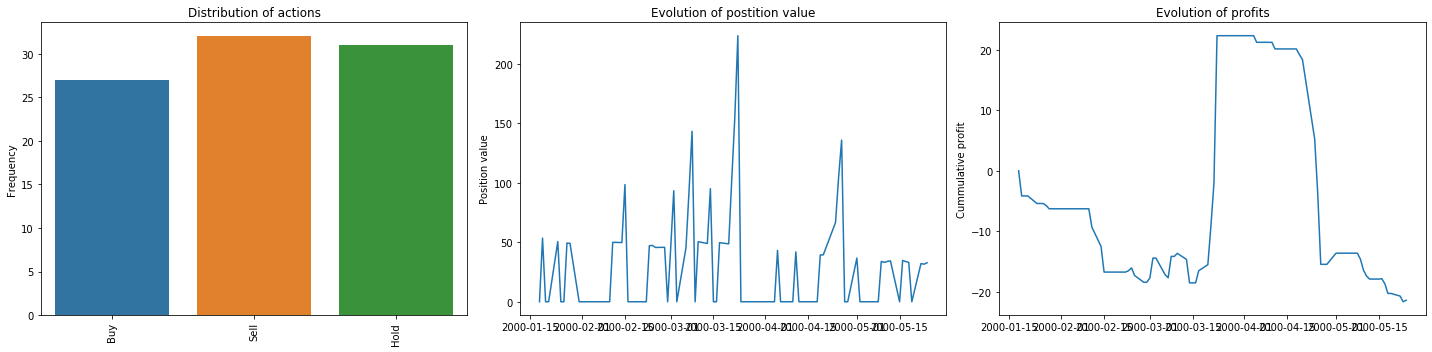

In [269]:
# Initilize environment
env = FirstEnvironment(data = data)

# Operate randomly
for i in range(90):
    # Choose a random action
    action = random.choice([0,1,2])
    
    # Execute action
    obs, reward, done, info = env.step(action)

# Print stats
env.render()
plot_stats(env)
plt.show()

## Dense Neural Network

In [270]:
def build_model_Dense(state_size, n_features, n_actions, hidden_size = 10, learning_rate = 0.005):
    # Create model
    model = Sequential()

    # Add layers
    model.add(Flatten(input_shape = (state_size,)))
    model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(n_actions, activation = 'linear'))
    
    # Compile
    model.compile(loss = "mean_squared_error", optimizer = Adam(lr = learning_rate))

    return model

### DQL

In [271]:
# Create environment
env = FirstEnvironment(data = data, time_horizon = 100, time_skip = 25)

# Create agent
model = build_model_Dense(env.time_horizon, env.n_features, env.n_actions)
agent = AgentDQN(env, model)

# Train the agent
agent = deep_q_learning(env, agent, num_episodes=5)

2020-06-07 23:42:02,686 : INFO Training DQL
2020-06-07 23:42:03,020 : DEBUG Running episode 0
2020-06-07 23:42:03,021 : DEBUG Running step 0
2020-06-07 23:42:12,970 : DEBUG Running step 100
2020-06-07 23:42:23,800 : DEBUG Finish at step 196
2020-06-07 23:42:23,800 : DEBUG Running episode 1
2020-06-07 23:42:23,801 : DEBUG Running step 0
2020-06-07 23:42:34,742 : DEBUG Running step 100
2020-06-07 23:42:45,863 : DEBUG Finish at step 196
2020-06-07 23:42:45,864 : DEBUG Running episode 2
2020-06-07 23:42:45,865 : DEBUG Running step 0
2020-06-07 23:42:58,231 : DEBUG Running step 100
2020-06-07 23:43:09,778 : DEBUG Finish at step 196
2020-06-07 23:43:09,778 : DEBUG Running episode 3
2020-06-07 23:43:09,779 : DEBUG Running step 0
2020-06-07 23:43:21,226 : DEBUG Running step 100
2020-06-07 23:43:31,851 : DEBUG Finish at step 196
2020-06-07 23:43:31,852 : DEBUG Running episode 4
2020-06-07 23:43:31,853 : DEBUG Running step 0
2020-06-07 23:43:42,750 : DEBUG Running step 100
2020-06-07 23:43:53,65

2020-06-07 23:43:53,665 : INFO Download data from MSFT


PROFITS: 0.000
POSITION VALUE: 0.000


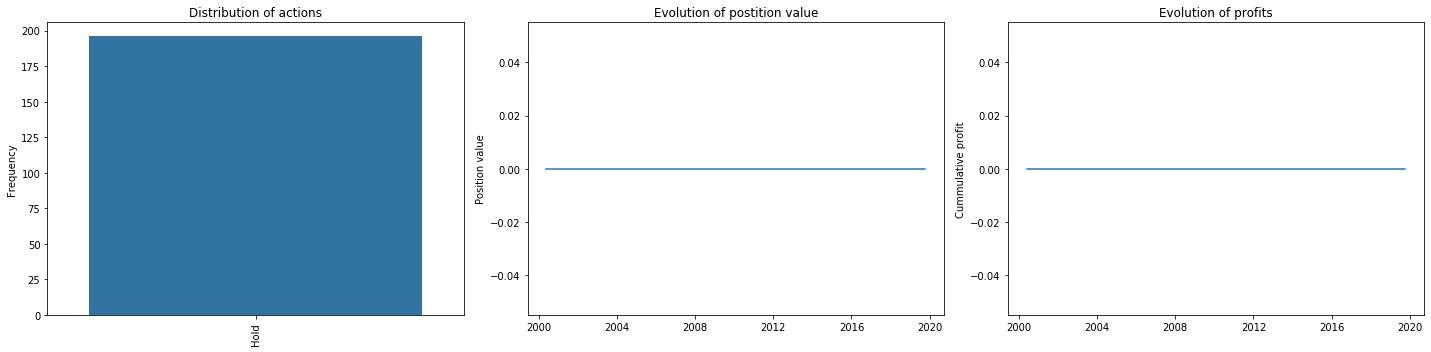

In [272]:
# Initilize environment
data2 = download_stock(stock = ['MSFT'], date_start = datetime(2000, 1, 1), date_end = datetime(2019, 12, 31))
env = FirstEnvironment(data = data2, time_horizon = 100, time_skip = 25)
state = env.reset()

# Operate randomly
for i in range(196):
    # Choose a random action
    probs = agent.q_network.predict(state)
    action = np.argmax(probs)
    
    # Execute action
    state, reward, done, info = env.step(action)
    
# Print stats
env.render()
plot_stats(env)
plt.show()

### DDQL

In [275]:
# Load environment
env = FirstEnvironment(data = data, time_horizon = 100, time_skip = 25)

# Create agent
model = build_model_Dense(env.time_horizon, env.n_features, env.n_actions)
agent = AgentDDQN(env, model)

# Train the agent
agent = double_deep_q_learning(env, agent, num_episodes=5)

2020-06-07 23:59:42,392 : INFO Training DDQL
2020-06-07 23:59:42,393 : DEBUG Running episode 0
2020-06-07 23:59:42,394 : DEBUG Running step 0
2020-06-07 23:59:52,926 : DEBUG Running step 100
2020-06-08 00:00:03,772 : DEBUG Finish at step 196
2020-06-08 00:00:03,773 : DEBUG Running episode 1
2020-06-08 00:00:03,774 : DEBUG Running step 0
2020-06-08 00:00:14,963 : DEBUG Running step 100
2020-06-08 00:00:25,523 : DEBUG Finish at step 196
2020-06-08 00:00:25,523 : DEBUG Running episode 2
2020-06-08 00:00:25,524 : DEBUG Running step 0
2020-06-08 00:00:36,710 : DEBUG Running step 100
2020-06-08 00:00:47,756 : DEBUG Finish at step 196
2020-06-08 00:00:47,757 : DEBUG Running episode 3
2020-06-08 00:00:47,757 : DEBUG Running step 0
2020-06-08 00:00:58,983 : DEBUG Running step 100
2020-06-08 00:01:10,327 : DEBUG Finish at step 196
2020-06-08 00:01:10,328 : DEBUG Running episode 4
2020-06-08 00:01:10,329 : DEBUG Running step 0
2020-06-08 00:01:22,520 : DEBUG Running step 100
2020-06-08 00:01:33,9

2020-06-08 00:04:22,839 : INFO Download data from MSFT


PROFITS: 0.000
POSITION VALUE: 0.000


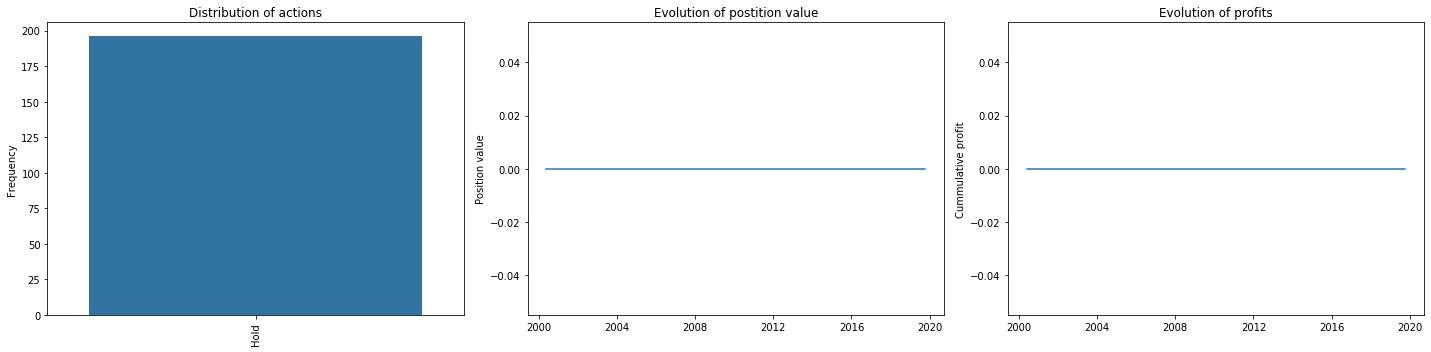

In [278]:
# Initilize environment
data2 = download_stock(stock = ['MSFT'], date_start = datetime(2000, 1, 1), date_end = datetime(2019, 12, 31))
env = FirstEnvironment(data = data2, time_horizon = 100, time_skip = 25)
state = env.reset()

# Operate randomly
for i in range(196):
    # Choose a random action
    probs = agent.q_network.predict(state)
    action = np.argmax(probs)
    
    # Execute action
    state, reward, done, info = env.step(action)
    
# Print stats
env.render()
plot_stats(env)
plt.show()

## Recurrent Neural Network

In [ ]:
def build_model_LSTM(state_size, n_features, n_actions, hidden_size = 10, learning_rate = 0.005):
    # Create model
    model = Sequential()

    # Add layers
    model.add(Flatten(input_shape = (state_size,)))
    model.add(LSTM(hidden_size, return_sequences = True))
    model.add(LSTM(hidden_size, return_sequences = True))
    model.add(Dense(n_actions, activation='linear'))

    # Compile
    model.compile(loss = "mean_squared_error", optimizer = Adam(lr = learning_rate))
    
    return model

### DQL

### DDQL